<h1> Symm4ml Computational Essay Final Draft</h1>
<h3> Author: Simeon Radev</h3>
<h3> Date: 12 May 2023</h3>

<h2>Introduction</h2>

<p> Recent work has been done on using small neural networks to model cellular automaton (CA)-like behavior, whereby such networks learn a set of "rules", represented as model parameters, to generate some target. 

Such models are already capable of generating a target pattern from a single seed pixel input, however, in their vanilla version, they cannot generate the same target in a different orientation without being explicitly retrained to do so. 

The goal of this project would therefore be to train a cellular automaton-like model that can learn the rules for generating a target, and can perform some simple transformations without having to retrain the model on such transformations. The motivation for this is that without such equivariance, the orientation of the model is a property of the grid space instead of the configuration of cells/pixels/nodes inside this space. Therefore this model is not fully self-organizing yet, however with such equivariant versions of the network, the orientation of the model would indeed become a property of the configuration of cells/pixels/nodes. </p>

<h2>Related Work</h2>
<p>The most direct influence for this project comes from <a href="https://distill.pub/2020/growing-ca/">this 2020 Distill paper</a>, entitled <i>Growing Neural Cellular Automata</i>. This work pioneers the idea of using a small, single neural network that is applied repeatedly over a series of discrete time steps to grow the final target pattern (which, in this case, is a single image). The relevant model parameters are then updated accordingly via backpropagation-through-time.</p>

<p>
        Prior to this seminal work, there have been previous attempts at using neural networks to learn the CA rules of different systems. An IEEE paper entitled <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9534060&tag=1"><i>It's Hard For Neural Networks To Learn The Game Of Life</i></a> performs basic experimentation with neural networks to try to implement a model that can learn the rules of Conway's Game of Life, given different states of the simulation. The authors found that in order for networks to learn to simulate this system correctly they must heavily overparameterize the model beyond the smallest network that can theoretically simulate this systems. 
    <br>
    
Attempts at getting neural networks to learn basic CA rules extend as far back as 1992, when the NeurIPS paper <a href="https://proceedings.neurips.cc/paper_files/paper/1992/file/d6c651ddcd97183b2e40bc464231c962-Paper.pdf"><i>Learning Cellular Automaton Dynamics
    with Neural Networks</i></a> discusses various CNN-like models which can simulate a specific class of cellular automata rules in 1D, as defined by Wolfram's <i>Theory and Applications of Cellular Automata</i>.
    <br>
    
The 2020 Distill publication is significant however because it is the first known instance of a small, single neural network being applied repeatedly over some number of timesteps to simulate the growth process of a CA. Prior work in the area relied largely on more traditional machine learning settings, whereby cellular automata were simulated using a single application of a large neural network, as opposed to repeated applications of a single, condensed network. The inspiration for the latter approach seems to come from biological processes and is a more natural way of approximating the behaviour of cellular automaton dynamics, as it represents a self-contained, single rule set that is universally applied to the entire system. 
</p>

<p>As a result of the successes of this approach, there have been many different continuations of this work. As an example, a 2021 NeurIPS paper, <a href="https://proceedings.neurips.cc/paper/2021/hash/af87f7cdcda223c41c3f3ef05a3aaeea-Abstract.html"><i>Learning Graph Cellular Automata</i></a> extends the idea of repeated applications of a single neural network to graphical structures. In the NeurIPS paper, a graph is distorted and the distortion is used as a seed input into a cellular automaton-like model, where repeated applications of this single model allows for the distorted graph to converge to some target shape.
</p>

<p>Even more recently, ICLR's 2022 conference published <a href="https://openreview.net/pdf?id=7fFO4cMBx_9"><i>Variational Neural Cellular Automata</i></a>, which uses a CA-based network as the decoder of a VAE. This extends the original Distill work by creating a network architecture which is capable of generating, or, "growing", multiple different targets, instead of being overfit on a single target.
</p>

<p>As we can see, the success of the original 2020 Distill publication which inspired this new approach to learning CA rules has spurred some active research in the area. Nevertheless, there are some drawbacks to the initial approach. In particular, the original model is presented as simulating a self-organizing process (namely, that of an "organisms" growth from a starting state to a final target state through intrinsic properties). However, the model is only capable of generating the target in the particular orientation in which it was trained. This means that the model's ability to successfully grow and persist is dependent on external properties of its space, as opposed to the intrinsic states of its cells. Thus, if we wanted to grow the same pattern in a different orientation, the naive approach would not allow for that. To address this issue, the authors do provide an experiment whereby the target image can be grown in a different orientation by taking in a rotation angle as an additional input. However this still poses certain limitation which will be further illustrated below with experiments.
</p>

<p>Finally, the same group of authors of the original publication presented a new paper in 2022, currently on on arxiv, called <a href="https://arxiv.org/pdf/2205.01681.pdf"><i>Growing Isotropic Neural Cellular Automata</i></a>. This latest work discusses the original implementation's problem of anisotropy and suggests various methods for fixing it. In particular, they make the anology that the original model's dependence on external properties of the space are analogous to a real-life organism being solely capable of growing while facing north. As a solution to this, they propose a somewhat complex approach of modifying the loss function from a simple MSE to a significantly more complicated one. While they do not provide their code for reproduction, this approach feels like an overly complicated and more unnatural solution to achieve model equivariance. The purpose of this project is therefore to present a first-principles approach, which constrains the architecture of the model to be equivariant without having to manipulate the loss function in any way.
</p>

<p>All of the equivariant aspects of our architecture come from the <a href="https://github.com/QUVA-Lab/e2cnn">e2cnn</a> library. 

<p>We should note that the original paper does attempt to address this issue by applying rotation

<p>Below we include a recreation of the experiments from the Distill blog, re-written in PyTorch from the original implementation in Tensorflow:</p>

<p style="color:red">TODO: Discuss more specifically their implementation and include graphic of model. Also, include briefly their follow-up with the isotropic version and how the methodology is different.</p>

As an overview of their model, and as it closely relates to the equivariant version we wrote, we now provide their original model implementation in PyTorch (the original is in Tensorflow)

<h4>Overview of original implementation</h4>

Because our work relies heavily on the original architecture of the inspiration behind this work, we present a brief overview of the important concepts introduced by the <a href="https://distill.pub/2020/growing-ca/">2020 Distill work</a>, as well as an implementation of their model in PyTorch (the original is in Tensorflow). We believe it important to present this here because the fundamental architectural design of the original work will heavily guide our design and understanding of its equivariant descendant.

Furthermore, a lot of the implementation provided here (such as the training class), will remain unchanged throughout the rest of the notebook as it is not the main focus of this project.

To start, we first define some necessary imports (note the dependance on a custom python module `utils` which includes helper functions for processing and displaying our work, but the relevant pieces of code should be wholly self-contained within this notebook):

device is cuda:2


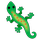

In [70]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

# PyTorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

# Equivariant library
import e2cnn
from e2cnn import gspaces

# Other dependencies 
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math
import PIL.Image, PIL.ImageDraw
import time

# Notebook dependencies
from IPython.display import clear_output, Image

# Import necessary functions from personal utils file
from utils import *

# For file reloading (remove before submission)
import importlib
import sys
importlib.reload(sys.modules['utils'])
from utils import *

# Get access to GPU
device_id = 2
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

## Global parameters used throughout
CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎"

USE_PATTERN_POOL = True # set in "persistent" mode

# Load and imshow the target image
target_img = load_emoji(TARGET_EMOJI)
imshow(target_img)

In [29]:
# Toggle this to train the below models instead 
SAVE = True

For now, we have made all necessary package imports and have defined some globals parameters. These parameters will remain unchanged as they are not the focus of this project, and so they are the same as the defaults defined in the original implementation.

Below, we show the seed image that is used by the original implementation, along with the target image. As we can see, it is just a single dot in the center of the image, with the entire grid initialized to zeroes, except for the center pixel which is initialized to ones (except for the first three RGB channels).

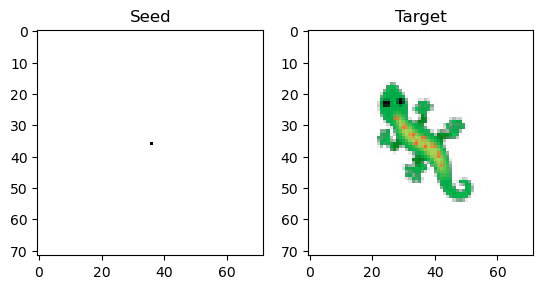

In [37]:
seed, pad_target = make_seed(target_img)
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0) # augment the seed pixel with a batch dimension

Now we need to define a class to contain the original CA model architecture, which is a close implementation of the original paper's model. Figure 1 below visualizes the basic concept:

<figure>
  <img src="images/original_model.svg" alt="Original Model Architecture" style="width:80%">
    <figcaption><b>Figure 1:</b> Original model architecture</figcaption>
</figure>

On a high level, the model works by repeatedly updating each cell/pixel in the input image according to information sourced from that pixel's 3x3 neighbourhood. This is done to reflect the local message-passing nature of a traditional cellular automaton. 

As a reminder, an individual cell $c$ in a cellular automaton determines its state at time $t+1$ using the information from its current state value at time $t$, and the state value of its neighbours, also at time $t$. The rule set of a cellular automata then defines how to use this information acquired at time $t$ to produce an update for the cell $c$ at time $t+1$. 

In a similar manner, the model architecture is devised to have two main components. The first acquires the information from a particular cell and its neighbours, and the second uses this information and processes it (applies a CA "rule") to produce an update for that cell.

To do this, the model extracts a single 3x3 patch from the input image, and applies three different filters to that patch in order to generate a one-dimensional perception vector that contains all the information a cell and its neighbours. In the original implementation the authors use hardcoded filters to do generate this perception vector. The identity matrix captures the state of the cell at time $t$, and the $Sobel_X$ and $Sobel_Y$ filters capture relevant information from the cell's neighbours (the abstract intuition for the usage of sobel filters is that they approximate gradients in discrete cases).

Once the perception vector is generated, the CA "rule" can be applied to produce an update for the center pixel of the patch. In practice, we use a neural network to learn this "rule", which is implemented as two dense layers in PyTorch, with a single ReLU activation used in between. We do not go into further detail here as this part of the network is extensively detailed in the original publication and, as we will see, will ultimately end up irrelevent to the goal of our project.

Given this intuition, we can now provide our implementation of the above model. The most relevant component of the following code cell is the `perceive` method of the `CAModelOriginal` class, which defines how the network should "perceive" a cell's neighbourhood. As illustrated in the Figure 1 above, three hardcoded filters are applied to each 3x3 patch of the input image. Of course, for implementation purposes, this computation is parallelized and the actual filter application is performed by PyTorch's convolution operation in 2D.

The `forward` method of that same class implements the "Standard Dense Layer" described in the above graphic, and largely follows the implementation of the original work (albeit translated to PyTorch).

<!-- We should also mention that the specific details of the forward pass of the model, like stochastic updates, will be used throughout, but are not the focus of this work and therefore will not be discussed in detail. Our main focus with this work is in examining the kinds of functions which can be used to generate perception vectors based on a cell's 3x3 local neighbourhood, and how to constrain that function space to be invariant to certain transformations. -->

In [9]:
# Define Model

class CAModelOriginal(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior (these are the default initializations in TF)
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    
  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch
    """
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = stacked_filters.tile((self.channel_n, 1, 1))
    y = F.conv2d(x, kernel[:, None, :, :], padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModelOriginal().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

Below is the training class which we define. It is fully decoupled from the equivariant nature of the input model, so this will be the same training instance we use throughout this notebook to train both equivariant and non-equivariant CA models. Figure 2 provides a brief illustration of the training methodology. A key difference between this training loop and more traditional ones is that here we apply the same model (described above) repeatedly for some $N$ number of steps (where $N$ is an integer drawn at random from [64, 96], just as in the original work).

The final output of the network after these $N$ steps is then compared with the target image using an $L_2$ loss, and the parameters of the model are updated via backpropagation-through-time. This training scheme remains unchanged throughout this notebook.

<figure>
  <img src="images/training_scheme.svg" alt="Training Scheme" style="width:80%">
    <figcaption><b>Figure 2:</b> Training scheme of CA network</figcaption>
</figure>

In [10]:
# Define training class

class Train:
    def __init__(self, ca_model, seed, target, lr=2e-3):
        """Initialize training object with model to train, seed and target

        :param ca_model: PyTorch model class object (instantiated)
        :param seed: PyTorch tensor of shape (H, W, C), initial seed to start training
        :param target: PyTorch tensor of shape (H, W, C), target image to learn
        """
        self.ca = ca_model
        self.seed = seed

        # Augment target tensor with batch dimension
        self.target = torch.repeat_interleave(target[None, ...], BATCH_SIZE, dim=0)
        self.lr = lr

        # Initialize optimizer with lr scheduler
        self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[4000], gamma=0.25)

        # Pool of training samples for "persistent" training mode
        self.pool = SamplePool(x=torch.repeat_interleave(self.seed[None, ...], POOL_SIZE, dim=0))    

        # Log the training progress
        self.loss_log = []
    
    def train(self, n_steps=1001):
        """Train the model stored in `self.ca` for `n_steps` training steps

        :param n_steps: int, Number of training steps
        :return: list, loss history         
        """
        start_time = time.time() # time training run
        
        for i in range(n_steps):
            
            # Very similar to original TF implementation
            if USE_PATTERN_POOL:
                batch = self.pool.sample(BATCH_SIZE)
                x0 = batch.x.detach() # batch.x requires grads by default (hence the .detach())

                loss_rank = self._loss_f(x0, self.target).argsort(descending=True)
                x0 = x0[list(loss_rank.detach().cpu().numpy())]
                x0[:1] = seed # to prevent catastrophic forgetting
            else:
                x0 = torch.repeat_interleave(self.seed[None, ...], BATCH_SIZE, 0)

            # Run through a single training step of the model (note this performs many updates)
            x, loss = self._train_step(x0)
            self.loss_log.append(loss)

            # Update pool
            if USE_PATTERN_POOL:
                batch.x[:] = x
                batch.commit()

            # Printing
            if i % 100 == 0:
                clear_output()

                # Visualize batch
                visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)

                # Plot loss
                plot_loss(self.loss_log)

            print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')
        
        elapsed_time = np.round((time.time() - start_time) / 60, decimals=4)
        print(f'\nElapsed time for training run on {n_steps} steps: {elapsed_time}')
        
        return self.loss_log, elapsed_time
        
    def _train_step(self, x):
        """Perform the update step some random number of times"""
        
        iter_n = np.random.randint(64, 97, dtype=np.int32)
        for _ in range(iter_n):
            # Forward pass of model
            x = self.ca(x)
            
        # Compute loss (note we must take the mean across the batch dimension)
        loss = self._loss_f(x, self.target).mean()
        
        # Compute gradients
        loss.backward()

        # Apply L2 normalization to parameter gradients as per original paper
        for p in self.ca.parameters():
            if p.grad is not None:
                p.grad = p.grad / (p.grad.norm() + 1e-8) 

        # Update parameters
        self.optim.step()

        # Clear previous gradients accumulated on parameters
        self.optim.zero_grad()

        # Update learning rate step
        self.scheduler.step()

        return x, loss.item()

    def _loss_f(self, output, target):
        """Custom l2 loss function. Compute mean-squared errors across
            batch dimension to be sorted for pooling."""
        return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


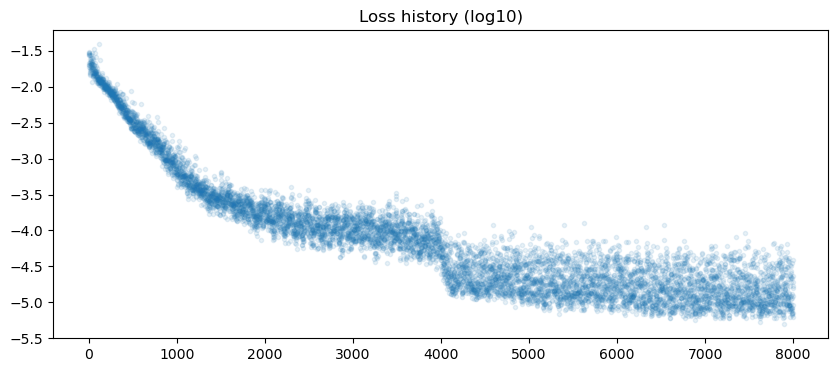

Training took approximately 19.0115 minutes


In [34]:
ca_original = load_ca_model(CAModelOriginal, 'original_model', device=device)
loss_log_original = load_np_array('original_model')
elapsed_time_original = load_np_array('original_model', foldername='train_time')

plot_loss(loss_log_original)
print(f"Training took approximately {elapsed_time_original.item()} minutes")

batch (before/after):


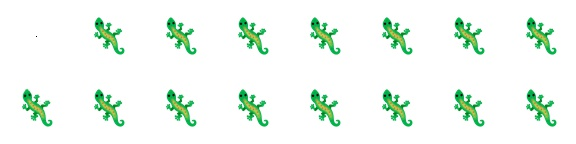

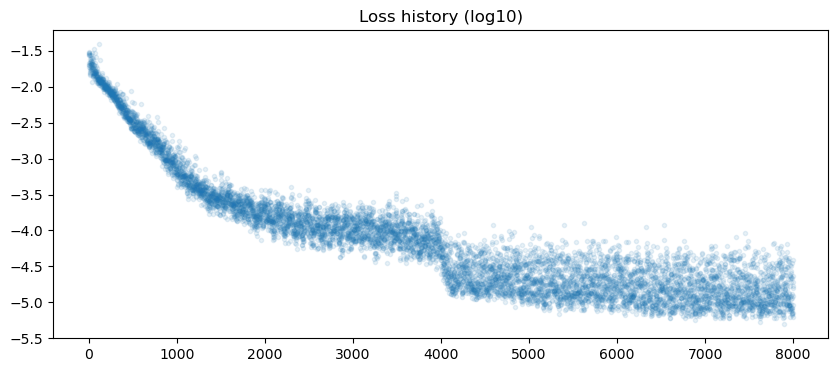

 step: 8001, log10(loss): -4.769
Elapsed time for training run on 8001 steps: 19.0115
Saved model original_model to disk
Saved array under loss_log/original_model name to disk
Saved array under train_time/original_model name to disk
CPU times: user 19min 4s, sys: 9.93 s, total: 19min 14s
Wall time: 19min 2s


In [19]:
%%time

# Original CA implementation training instance
SAVE = False
if SAVE:
    ca_original = CAModelOriginal().to(device)
    train_original = Train(ca_original, seed.to(device), pad_target.to(device))

    loss_log_original, elapsed_time_original = train_original.train(n_steps=8001)

    # Save stuff
    filename = "original_model"
    save_ca_model(ca_original, filename)
    save_np_array(loss_log_original, filename)
    save_np_array(elapsed_time_original, filename, foldername="train_time")
else:
    

100%|█████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 617.38it/s]


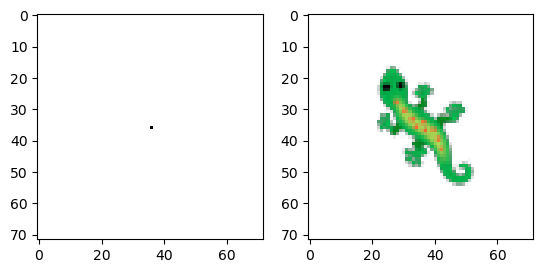

In [21]:
_ = simulate_model(ca_original, seed.unsqueeze(0), 90, device=device)

In [35]:
# Note, to change the lenght of the video (and the number of update steps to perform), change the `n_steps` variable

make_video(models=[ca_original], seed=seed, n_steps=120, video_name="original_ca", device=device)
mvp.ipython_display('original_ca.mp4')

100%|█████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 155.72it/s]


Moviepy - Building video original_ca.mp4.
Moviepy - Writing video original_ca.mp4



Moviepy - Done !
Moviepy - video ready original_ca.mp4


We observe that the original model is able to reconstruct the target image quite successfully, as expected. However, as described above, the current model is limited in that it does not represent a fully self-organizing process, as the success of the model's growth process is dependent on external factors not intrinsic to the model itself. 

The original publication does describe one possible method for growing the target in an orientation other than the one in which it was trained, by multiplying the sobel filters by a rotation matrix parameterized by some angle, theta. We also implement this method in the code above and visualize its performance below:

In [82]:
# In the below, we call a function which generates a video given a list of angles with which to rotate the target, 
# as well as the corresponding time steps at which to do so. 

models = [ca_original]
# time_steps = [10, 20, 30, 40]
# angles = [0, 90, 180, 270]
time_steps = [0]
angles = [90]
make_video_with_rotations(models=models, seed=seed, n_steps=120, time_steps=time_steps, angles=angles, device=device)

print(f"\nShowing growth of target when rotations {angles} applied at update steps {time_steps}")
mvp.ipython_display('original_rot.mp4')

100%|█████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 209.22it/s]


Moviepy - Building video original_rot.mp4.
Moviepy - Writing video original_rot.mp4



Moviepy - Done !
Moviepy - video ready original_rot.mp4

Showing growth of target when rotations [90] applied at update steps [0]


As we can see, the above video illustrates that the naive approach of using rotation matrices to grow the target in a different orientation works when the image is rotated from the start. 

However, as we can see from the demo below, when multiple rotations are performed during the growth process of the target, the reconstruction fails quite spectacularly:

In [84]:
 models = [ca_original]
time_steps = [20, 50, 70]
angles = [90, 180, 270]
name = 'original_rot_fail.mp4'
make_video_with_rotations(models=models, seed=seed, n_steps=220, time_steps=time_steps, angles=angles, video_name=name, device=device)

print(f"\nShowing growth of target when rotations {angles} applied at update steps {time_steps}")
mvp.ipython_display(name)

100%|█████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 253.64it/s]


Moviepy - Building video original_rot_fail.mp4.
Moviepy - Writing video original_rot_fail.mp4



Moviepy - Done !
Moviepy - video ready original_rot_fail.mp4

Showing growth of target when rotations [90, 180, 270] applied at update steps [20, 50, 70]


no rotations applied/rotations applied;


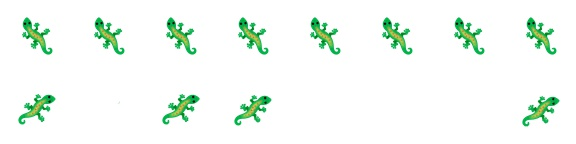

In [49]:
x = x0.clone()
x_rot = x0.clone()
angles = [0, 90, 180, 270]
angle_formula = lambda a : a/360.0 * 2 * np.pi
angle = angles[0]
for i in range(180):
    if i == 10:
        angle = angle_formula(angles[1])
    if i == 30:
        angle = angle_formula(angles[2])
    if i == 40:
        angle = angle_formula(angles[3])        
    x = ca_original(x.to(device))
    x_rot = ca_original(x_rot.to(device), angle=angle)

print("no rotations applied/rotations applied;")
visualize_batch(to_rgba(x).detach().cpu(), to_rgba(x_rot).detach().cpu(), verbose=False)


From the above demos we see that although applying a rotation matrix does appear to work in some cases, it does tend to fail in many trivial situations. This can be further analyzed with the demo presented by the <a href="https://distill.pub/2020/growing-ca/">original blog post</a> on Distill.

The aim of this project is therefore to construct a more robust method for growing the target image in a new orientation from the one in which it was trained by using ideas from  geometric deep learning related to equivariant and invariant models, which are further discussed below.

<h2>Background</h2>
<p>The goal of this project is to make an equivariant version of either a 
two-dimensional or three-dimensional cellular automaton-like network, using 
ideas from the two main papers cited above. In the three-dimensional case 
this could obviously done with the e3nn library and standard concepts of 
equivariance in three-dimensional space covered in the class. 

If, however, a two-dimensional route is pursued, the equivariant model could potentially be implemented without such additional library. I am still unclear on how this would be done and would need to spend more time ideating this as well as discussing with others. </p>

<p style="color:red">TODOL: Include more math and discuss the group that will be used. This is the place for theoretical overview.<p>

<h2>Methods</h2> The models that would need to be built would be similar to the ones described in the above papers, with equivariance being additionally implemented. 

<p>As described above, we plan to construct an equivariant end-to-end model cellular automaton by making learnable perception kernels which are invariant to 90-degree rotations (corresponding to elements from the cyclic group $C_{4}$). Our decision to limit the model's equivariance to 90-degree rotations is mainly due to constraints in training time. As discussed below, we also tried training networks equivariant to $C_{8}$, which yielded significantly worse results and respectively intolerable training times (for the parameters of a class project). We assume that improving the performance of our model on this larger group of rotations would also require increasing the size of our architecture, which additionally would increase training times. </p> 

<p style="color:red">
    TODO: This is the bulk. If time permits, include some individual cells of the experimentation from the playground 
    (showcasing how the library works on small examples). 
    <br>
    Then, include the code implementations below (just for model training and class definition). Experiments will be later.
</p>

<p>To begin, we first define a new model class with an invariant perception layer. This class lets the caller select between the trivial and regular representations to use in the hidden layer of the model. As the trivial representation already produces scalras (i.e. invariant features), we do not need any explictily invariant operations to convert to invariant features. However, when the regular representation is used in the hidden layers of the model, we need an invariant operation since </p>

<h2>References</h2>

S Wolfram, <i>Theory and Applications of Cellular Automata</i> (World Scientific, 1986) 